In [ ]:
!pip install transformers datasets nltk sentence-transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 100.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1


In [ ]:
import random
from datasets import Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from tokenizers import Tokenizer, normalizers, pre_tokenizers
import re
from transformers import Trainer, TrainingArguments, EvalPrediction
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu
import os
from sentence_transformers import SentenceTransformer, util
import torch
from torch.utils.data import DataLoader
import gc
import numpy as np
import json

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def OpenFile(filename):
    with open(filename, 'r', encoding='UTF-8') as file:
        file_string = file.read()
    file.close()
    return file_string

In [ ]:
def LoadData(similar_pairs_text_path):

  data = OpenFile(similar_pairs_text_path)

  # Split the data into pairs. built the text file so the first sentence in the pair is simple english and the second is regular
  pairs = data.strip().split('\n\n')
  sentence_pairs = [pair.split('\n') for pair in pairs]

  # required format for T5 model
  formatted_pairs = [{"input_text": "translate English to Simple English: " + pair[1], "target_text": pair[0]} for pair in sentence_pairs]

  return formatted_pairs

In [ ]:
def BuildDatasets(formatted_pairs):

  random.shuffle(formatted_pairs)

  # 90% train, 10% test
  train_size = int(0.9 * len(formatted_pairs))
  val_size = 0

  train_data = formatted_pairs[:train_size]
  val_data = formatted_pairs[train_size:train_size + val_size]
  test_data = formatted_pairs[train_size + val_size:]

  train_dataset = Dataset.from_list(train_data)
  val_dataset = Dataset.from_list(val_data)
  test_dataset = Dataset.from_list(test_data)

  return train_dataset, val_dataset, test_dataset

In [ ]:
def BuildTokenizer():

    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.normalizer = normalizers.Sequence([
    normalizers.Replace(",", " , "),  # Preserve comma as a separate token
    normalizers.Replace(".", " . "),  # Preserve dot as a separate token
    normalizers.Replace("?", " ? "),  # Preserve question mark as a separate token
    normalizers.Replace("!", " ! "),  # Preserve exclamation mark as a separate token
    ])
    return tokenizer

In [ ]:
def Tokenization(sample):

    tokenizer = BuildTokenizer()
    input_texts = sample['input_text']
    target_texts = sample['target_text']
    input_cleaned_texts = []
    target_cleaned_texts = []
    for i in range(len(input_texts)): # len(input_texts)=len(target_texts)
      input_cleaned_texts.append(re.sub(r'[^a-zA-Z0-9 ,.\'\"?!:]', ' ', input_texts[i]))
      target_cleaned_texts.append(re.sub(r'[^a-zA-Z0-9 ,.\'\"?!:]', ' ', target_texts[i]))
    input_encodings = tokenizer(input_cleaned_texts, padding='max_length', truncation=True, max_length=512)
    target_encodings = tokenizer(target_cleaned_texts, padding='max_length', truncation=True, max_length=512)
    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

In [ ]:
def plot_loss(loss_values):

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
    plt.title('Training loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

In [ ]:
def Training(tokenized_train_dataset, tokenized_val_dataset):
    print("Train...")
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    #model.to('cpu')
    training_args = TrainingArguments(
        output_dir='/content/drive/MyDrive/NLP_Proj/model_results_T5',
        num_train_epochs=10,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/content/drive/MyDrive/NLP_Proj/model_logs_T5',
        logging_steps=10,
        evaluation_strategy="no", # Disable evaluation
        fp16=True,
        save_strategy="no",
        load_best_model_at_end=True,
        remove_unused_columns=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset
    )

    loss_values = []

    # Training loop with checkpointing
    for epoch in range(int(training_args.num_train_epochs)):
        print(f"Starting epoch {epoch+1}/{int(training_args.num_train_epochs)}")
        if epoch > 0:
            # Load model and optimizer state from checkpoint
            checkpoint_dir = f'/content/drive/MyDrive/NLP_Proj/model_results_T5/checkpoint-{epoch-1}'
            model = T5ForConditionalGeneration.from_pretrained(checkpoint_dir)
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_train_dataset
            )

        train_output = trainer.train()
        loss_values.append(train_output.training_loss)
        # Save model and optimizer state
        checkpoint_dir = f'/content/drive/MyDrive/NLP_Proj/model_results_T5/checkpoint-{epoch}'
        trainer.save_model(checkpoint_dir)
        trainer.save_state()
        torch.cuda.empty_cache()  # Clear GPU memory

    plot_loss(loss_values)
    return model, trainer

In [ ]:
def Test(trainer, tokenized_test_dataset, full_path):
    print("Test...")
    trainer.model.to('cpu')
    test_results = {}
    avg_loss = 0.0
    os.makedirs(os.path.dirname(full_path), exist_ok=True)
    with open(full_path, 'w') as file:
      for i, example in enumerate(tokenized_test_dataset):
          sentence = example['input_text']
          simple_sentence = example['target_text']
          # print(sentence)
          # print(simple_sentence)

          # Ensure batch is in the correct format
          # Convert each tensor in the batch to CPU
          input_ids = torch.tensor([example['input_ids']]).to('cpu')
          attention_mask = torch.tensor([example['attention_mask']]).to('cpu')
          labels = torch.tensor([example['labels']]).to('cpu')

          # Create a batch dictionary
          batch = {
              'input_ids': input_ids,
              'attention_mask': attention_mask,
              'labels': labels
          }

          with torch.no_grad():
              outputs = trainer.model(input_ids=batch['input_ids'],
                                      attention_mask=batch['attention_mask'],
                                      labels=batch['labels'])
              loss = outputs.loss.item()
              avg_loss += loss

          test_results[i] = {
              'sentence': sentence,
              'simple_sentence': simple_sentence,
              'loss': loss
          }
          file.write(json.dumps(test_results[i]) + '\n')
      avg_loss /= len(test_results)
      file.write("".join(f"\n Average test loss: {avg_loss}\n"))
    file.close()
    print("".join(f"Average test loss: {avg_loss}\n"))

In [ ]:
def SaveModels(saving_models_path, model, tokenizer):

  path = os.path.join(saving_models_path, 'english_simple_T5/')
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)

In [ ]:
def SaveTestDataset(tokenized_test_dataset, path_dataset):

  tokenized_test_dataset.save_to_disk(path_dataset)

In [ ]:
def main(similar_pairs_text_path, test_full_path_logs, saving_models_path, path_dataset):

  formatted_pairs = LoadData(similar_pairs_text_path)
  train_dataset, val_dataset, test_dataset = BuildDatasets(formatted_pairs)
  tokenizer = BuildTokenizer()

  tokenized_train_dataset = train_dataset.map(Tokenization, batched=True)
  tokenized_val_dataset = val_dataset.map(Tokenization, batched=True)
  tokenized_test_dataset = test_dataset.map(Tokenization, batched=True)

  model, trainer = Training(tokenized_train_dataset, tokenized_val_dataset)

  Test(trainer, tokenized_test_dataset, test_full_path_logs)

  SaveModels(saving_models_path, model, tokenizer)
  SaveTestDataset(tokenized_test_dataset, path_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map:   0%|          | 0/2664 [00:00<?, ? examples/s]

Map:   0%|          | 0/296 [00:00<?, ? examples/s]

Train...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting epoch 1/10


Step,Training Loss
10,14.764100
20,14.651100
30,14.082300
40,14.262600
50,14.292800
60,13.446400
70,12.648500
80,11.989200
90,11.166600
100,10.718500


Starting epoch 2/10


Step,Training Loss
10,0.068400
20,0.035700
30,0.054300
40,0.047300
50,0.054800
60,0.045500
70,0.038600
80,0.062300
90,0.041200
100,0.038400


Starting epoch 3/10


Step,Training Loss
10,0.056000
20,0.029100
30,0.044600
40,0.038200
50,0.043400
60,0.036200
70,0.031000
80,0.049900
90,0.032400
100,0.030300


Starting epoch 4/10


Step,Training Loss
10,0.047300
20,0.024800
30,0.038100
40,0.032200
50,0.035300
60,0.030600
70,0.026300
80,0.041400
90,0.026600
100,0.024900


Starting epoch 5/10


Step,Training Loss
10,0.041300
20,0.021400
30,0.033200
40,0.027600
50,0.029400
60,0.026100
70,0.022600
80,0.035100
90,0.022300
100,0.020600


Starting epoch 6/10


Step,Training Loss
10,0.037000
20,0.019100
30,0.029700
40,0.024000
50,0.024800
60,0.022600
70,0.019600
80,0.029900
90,0.018900
100,0.017200


Starting epoch 7/10


Step,Training Loss
10,0.033700
20,0.017300
30,0.027100
40,0.021300
50,0.021600
60,0.019900
70,0.017400
80,0.025600
90,0.016400
100,0.014500


Starting epoch 8/10


Step,Training Loss
10,0.031100
20,0.015900
30,0.024400
40,0.019400
50,0.019200
60,0.017600
70,0.015100
80,0.022000
90,0.014100
100,0.012200


Starting epoch 9/10


Step,Training Loss
10,0.029300
20,0.015100
30,0.022800
40,0.017700
50,0.017100
60,0.015600
70,0.013400
80,0.019000
90,0.012400
100,0.010400


Starting epoch 10/10


Step,Training Loss
10,0.028100
20,0.014300
30,0.021200
40,0.016300
50,0.015600
60,0.013800
70,0.011800
80,0.016400
90,0.011000
100,0.009000


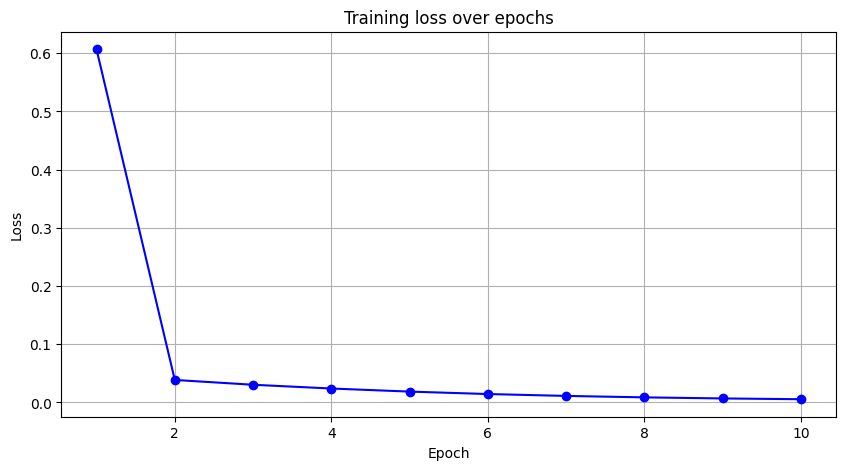

Test...
Average test loss: 0.06959771684177139



Saving the dataset (0/1 shards):   0%|          | 0/296 [00:00<?, ? examples/s]

In [ ]:
similar_pairs_text_path = '/content/drive/MyDrive/NLP_Proj/similar/similar_pairs.txt'
test_full_path_logs = '/content/drive/MyDrive/NLP_Proj/test_T5/test_log.jsonl'
saving_models_path = '/content/drive/MyDrive/NLP_Proj/saving_models_T5'
path_dataset = '/content/drive/MyDrive/NLP_Proj/saving_datasets_T5'

main(similar_pairs_text_path, test_full_path_logs, saving_models_path, path_dataset)